# Gather insights from the experiments run on GCP

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from common.utils import check_missing_experiments, join_df
from common.metrics import *

## Define the TTA Formula 

In [ ]:
# Calculate time to accuracy for different accuracies
def tta_crossbow(acc:int, df: pd.DataFrame, acc_column='accuracy', time_column='epoch_duration'):
    """Computes the tta as in the crossbow paper
    where the tta is the median of the last 5 epochs"""

    res = []
    for _, row in df.iterrows():
        done = False
        dur, accuracy = row[time_column], row[acc_column]
        
        for idx, (t, a) in enumerate(zip(dur, accuracy[:len(dur)])):
            
            # if there are less than 5 elements behind, continue
            if idx < 4:
                continue
                
            # calculate the median of the next five elements
            if np.median(accuracy[idx - 4:idx+1]) >= acc:
                res.append(t)
                done = True
                break

        if not done:
            res.append(np.nan)

    return res


def tta(acc:int, df:pd.DataFrame,  acc_column='accuracy', time_column='epoch_duration'):
    
    
    res = []
    for _, row in df.iterrows():
        done=False
        dur, accuracy = row[time_column], row[acc_column]
        
        for idx, (t, a) in enumerate(zip(dur, accuracy[:len(dur)])):
         
            if a >= acc:
                res.append(t)
                done = True
                break

        if not done:
            res.append(np.nan)

    return res
        

# KubeML Experiments

How to treat the kubeml experiments

### Load the train results

In [ ]:
df = join_df('./results/resnet/train')
df = df[df.default_parallelism > 1]

In [ ]:
df

In [ ]:
# get duplicated rows
df[df.duplicated(['hash'], keep=False)]

Define the extra variables

In [ ]:
# Set the acc to the final accuracy
df['acc'] = df.accuracy.map(lambda a: a[-1])

# Set the time to the sum of the epoch durations
df['time'] = df.epoch_duration.map(lambda t: t[-1])

# Set the parallelism to the first since it is constant
df.parallelism = df.parallelism.map(lambda l:l[0])

# change -1 to inf so the order is right in the plot
df.k = df.k.map(lambda val: float('inf') if val == -1 else val)

df['global_batch'] = df.batch_size * df.parallelism




In [ ]:
# compute the ttas
df['tta_69'] = tta(69, df)
df['tta_cross_69'] = tta_crossbow(69, df)

# compute the ttas
df['tta_67'] = tta(67, df)
df['tta_cross_67'] = tta_crossbow(67, df)

# compute the ttas
df['tta_70'] = tta(70, df)
df['tta_cross_70'] = tta_crossbow(70, df)

### For the metrics in resnet

In [ ]:
metrics = join_df('./results/resnet/metrics')
m = metrics.rename(columns={'exp_name':'id'})

### For the metrics in the lenet

The first replication does not have the proper format, so we need to reformat it and combine it with the train results

In [ ]:
metrics1 = join_df('./results/lenet/metrics/1/')
metrics2 = join_df('./results/lenet/metrics/2/')
metrics3 = join_df('./results/lenet/metrics/3/')

cpu = metrics1.groupby('exp_name')['cpu'].apply(list)
mem = metrics1.groupby('exp_name')['mem'].apply(list)
exps = metrics1.groupby('exp_name')['exp_name']

metrics1 = pd.DataFrame({
    'cpu':cpu,
    'mem':mem
})
metrics1['exp_name'] = metrics1.index

# concat all metrics and rename the exp_name as in the train
m = pd.concat([metrics1, metrics2, metrics3], ignore_index=True)
m.rename(columns={'exp_name':'id'}, inplace=True)


Now we need to add extra summary columns to the metrics

In [ ]:
# functions to compute the mean of each and add columns
m['mem'] = m['mem'].map(lambda l: l[0] if isinstance(l[0], list) else l)
m['cpu'] = m['cpu'].map(lambda l: l[0] if isinstance(l[0], list) else l)

# cpu util
m['cpu_mean'] = m['cpu'].map(lambda l: np.mean([s.percent for s in l]))

# gpu mean mem and util
m['gpu_0_mean_usage'] = m['gpu_0'].map(lambda l: np.mean([s.load for s in l if s.mem_used != 0]) if not isinstance(l, float) else l)
m['gpu_1_mean_usage'] = m['gpu_1'].map(lambda l: np.mean([s.load for s in l if s.mem_used !=0]) if not isinstance(l, float) else l)
m['gpu_0_mean_memory'] = m['gpu_0'].map(lambda l: np.mean([s.mem_used for s in l if s.mem_used != 0])if not isinstance(l, float) else l)
m['gpu_1_mean_memory'] = m['gpu_1'].map(lambda l: np.mean([s.mem_used for s in l if s.mem_used != 0])if not isinstance(l, float) else l)
m['gpu_usage'] = (m['gpu_0_mean_usage'] + m['gpu_1_mean_usage']) /2

# memory mean util
m['mem_mean'] = m['mem'].map(lambda l: np.mean([s.percent for s in l]))

#### Combine and Save the whole experiment

In [ ]:
d = df.merge(m, on='id')
d.to_pickle('./dataframes/resnet_kubeml.pkl')


# TensorFlow Experiments

How to treat the TF experiments

In [ ]:
folder = 'resnet_new'
df = join_df(f'./results/tf/{folder}/train/1/', f'./results/tf/{folder}/train/2', f'./results/tf/{folder}/train/3')

# Set the acc to the final accuracy
df['acc'] = df.val_accuracy.map(lambda a: a[-1])

# Set the time to the sum of the epoch durations
df['time'] = df.times.map(lambda t: t[-1])



In [ ]:
# Define the TTA
df['tta_67'] = tta(0.67, df, time_column='times', acc_column='val_accuracy')
df['tta_cross_67'] = tta_crossbow(0.67, df, time_column='times', acc_column='val_accuracy')

df['tta_69'] = tta(0.69, df, time_column='times', acc_column='val_accuracy')
df['tta_cross_69'] = tta_crossbow(0.69, df, time_column='times', acc_column='val_accuracy')

df['tta_70'] = tta(0.70, df, time_column='times', acc_column='val_accuracy')
df['tta_cross_70'] = tta_crossbow(0.70, df, time_column='times', acc_column='val_accuracy')


## Merge the metrics from different  folders


In [ ]:
m = join_df(f'./results/tf/{folder}/metrics/1/', f'./results/tf/{folder}/metrics/2', f'./results/tf/{folder}/metrics/3')

In [ ]:
# functions to compute the mean of each and add columns
m['mem'] = m['mem'].map(lambda l: l[0] if isinstance(l[0], list) else l)
m['cpu'] = m['cpu'].map(lambda l: l[0] if isinstance(l[0], list) else l)

# cpu util
m['cpu_mean'] = m['cpu'].map(lambda l: np.mean([s.percent for s in l]))

# gpu mean mem and util
m['gpu_0_mean_usage'] = m['gpu_0'].map(lambda l: np.mean([s.load for s in l if s.mem_used != 0]) if not isinstance(l, float) else l)
m['gpu_1_mean_usage'] = m['gpu_1'].map(lambda l: np.mean([s.load for s in l if s.mem_used !=0]) if not isinstance(l, float) else l)
m['gpu_0_mean_memory'] = m['gpu_0'].map(lambda l: np.mean([s.mem_used for s in l if s.mem_used != 0])if not isinstance(l, float) else l)
m['gpu_1_mean_memory'] = m['gpu_1'].map(lambda l: np.mean([s.mem_used for s in l if s.mem_used != 0])if not isinstance(l, float) else l)
m['gpu_usage'] = (m['gpu_0_mean_usage'] + m['gpu_1_mean_usage']) /2

# memory mean util
m['mem_mean'] = m['mem'].map(lambda l: np.mean([s.percent for s in l]))

Join on the index

In [ ]:
df = df.join(m)

Save the experiments

In [ ]:
df.to_pickle('./dataframes/resnet_new_tensorflow.pkl')

# Visualization of Results


Set the color palette

In [ ]:
green_red_palette = ['#264653', '#2A9D8F', '#E9C46A', '#F4A261', '#E76F51']
blue_yellow_palette=  ['#0077b6', '#d62828', '#f77f00', '#fcbf49', '#eae2b7']
cool_p = ['#f87575', '#ffa9a3', '#b9e6ff', '#5c95ff', '#7e6c6c']
wall_p = ['#e63946', '#f1faee', '#a8dadc', '#457b9d', '#1d3557']

sns.palplot(sns.color_palette(blue_yellow_palette))


sns.set_theme(style='whitegrid', palette=blue_yellow_palette, )
sns.set_context('talk')
# sns.set_palette(blue_yellow_palette)

# Read the experiments file

### Load all of the dataframes

In [ ]:
# load the tf experiments
resnet = pd.read_pickle('./dataframes/resnet_new_tensorflow.pkl')
lenet = pd.read_pickle('./dataframes/lenet_tensorflow.pkl')

lenet.rename(columns={
    'loss':'train_loss',
    'val_accuracy':'accuracy',
    'val_loss':'validation_loss',
    'times':'epoch_duration',
    'accuracy':'train_accuracy',
    'val_accuracy':'accuracy'
}, inplace=True)
lenet['system'] = 'tensorflow'
lenet['acc'] = 100*lenet['acc']
lenet['accuracy'] = lenet['accuracy'].map(lambda l: [100*n for n in l])

# rename columns in the TF dataframes to adhere to the kubeml ones
resnet.rename(columns={
    'loss':'train_loss',
    'val_accuracy':'accuracy',
    'val_loss':'validation_loss',
    'times':'epoch_duration',
    'accuracy':'train_accuracy',
    'val_accuracy':'accuracy'
}, inplace=True)
resnet['system'] = 'tensorflow'
resnet['acc'] = 100*resnet['acc']
resnet['accuracy'] = resnet['accuracy'].map(lambda l: [100*n for n in l])


# set the columns of the 

# load the kubeml experiments
kuberesnet = pd.read_pickle('./dataframes/resnet_kubeml.pkl')
kuberesnet['model'] = 'resnet'
kuberesnet['system'] = 'kubeml'
# kuberesnet['tta_70'] = tta(70, kuberesnet)
# kuberesnet['tta_cross_70'] = tta_crossbow(70, kuberesnet)

kubelenet = pd.read_pickle('./dataframes/lenet_kubeml.pkl')
kubelenet['model'] = 'lenet'
kubelenet['system'] = 'kubeml'


In [ ]:
# save the full resnet stuff
r.to_pickle('./dataframes/resnet_new.pkl')

In [ ]:
r = pd.concat([resnet, kuberesnet], ignore_index=True)
r
# resnet

### Create new columns for representation

- Final accuracy
- Total time taken
- Parallelism

### Plot the Correlations between the K, Batch and Parallelism with time and accuracy

In [ ]:
corr = df[['k', 'batch_size', 'parallelism', 'acc', 'time']].corr()
sns.heatmap(corr,
            annot=True,
)

# plt.savefig('./figures/resnet34/heat.png', dpi=300)


In [ ]:
df.sort_values('time')

mean = df.groupby('hash').mean()

### Get the max accuracies and times and check the parameters used

In [ ]:
# get the max accuracies
df[['k', 'parallelism', 'acc','batch_size','time']].sort_values(by='time', ascending=True)

## Calculate TTA with different accuracies



In [ ]:
s = df.sort_values('tta_cross_99')[['k', 'batch_size', 'parallelism', 'tta_cross_99', 'tta_99', 'acc', 'accuracy', 'epoch_duration']]

# plot the best
best = s.iloc[0]
best


x = range(1, len(best.accuracy)+1)
plt.figure()
plt.title(f'Best tta_99 (B={best.batch_size}, k={best.k}, P={best.parallelism})')
sns.lineplot(x=best.epoch_duration, y = best.accuracy)
sns.lineplot(x=best.epoch_duration, y= 99)
plt.scatter(best.tta_cross_99, 99, marker='X', s=60, c='r')
plt.xlabel('Time (s)', fontsize=15)
plt.ylabel('Accuracy (%)', fontsize=15)

# plt.savefig('./figures/gpu/best.png', dpi=300)


# Plot the resnet results KubeML vs Tensorflow

In [ ]:
#Define the colors used
tf_color = '#FF6F00'
kubecolor = '#316CE6'



## LeNet Results

In [ ]:
l = pd.read_pickle('./dataframes/lenet.pkl')

### Plot the Accuracy and Train Loss Progression

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=False, figsize=(20, 6))

# get the best results
tf = l[l.system=='tensorflow']
ml = l[l.system =='kubeml']
sample = tf.iloc[5]
kubesample = ml.iloc[87]

# sort for tta69 and show

# 1) plot the validation accuracy of TF
sns.lineplot(x=sample.epoch_duration[:30],
             y=sample.accuracy[:30],
             data=sample, 
            ax=ax1, 
            label='TensorFlow',
            color='#FF6F00')

# 2) plot the validation accuracy of KubeML
sns.lineplot(x=kubesample.epoch_duration,
             y='accuracy',
             data=kubesample, 
            ax=ax1, 
            label='KubeML',
            color='#316CE6')

ax1.set_ylim([97, 100])
ax1.set_xlabel('Time (sec)')



# plot the line at 69%
sns.lineplot(x=kubesample.epoch_duration,
            y=99,
            ax=ax1,
            color='red')

# 3) Plot the train loss
sns.lineplot(x=sample.epoch_duration[:30],
             y=sample.train_loss[:30],
             data=sample, 
            ax=ax2, 
            label='TensorFlow',
            color='#FF6F00')

# 3) Plot the train loss
sns.lineplot(x=kubesample.epoch_duration,
             y='train_loss',
             data=kubesample, 
            ax=ax2, 
            label='KubeML',
            color='#316CE6')

ax2.set_xlabel('Time (sec)')

### Plot the whole comparison

c:\users\diego\cs\qpe\venv\lib\site-packages\ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


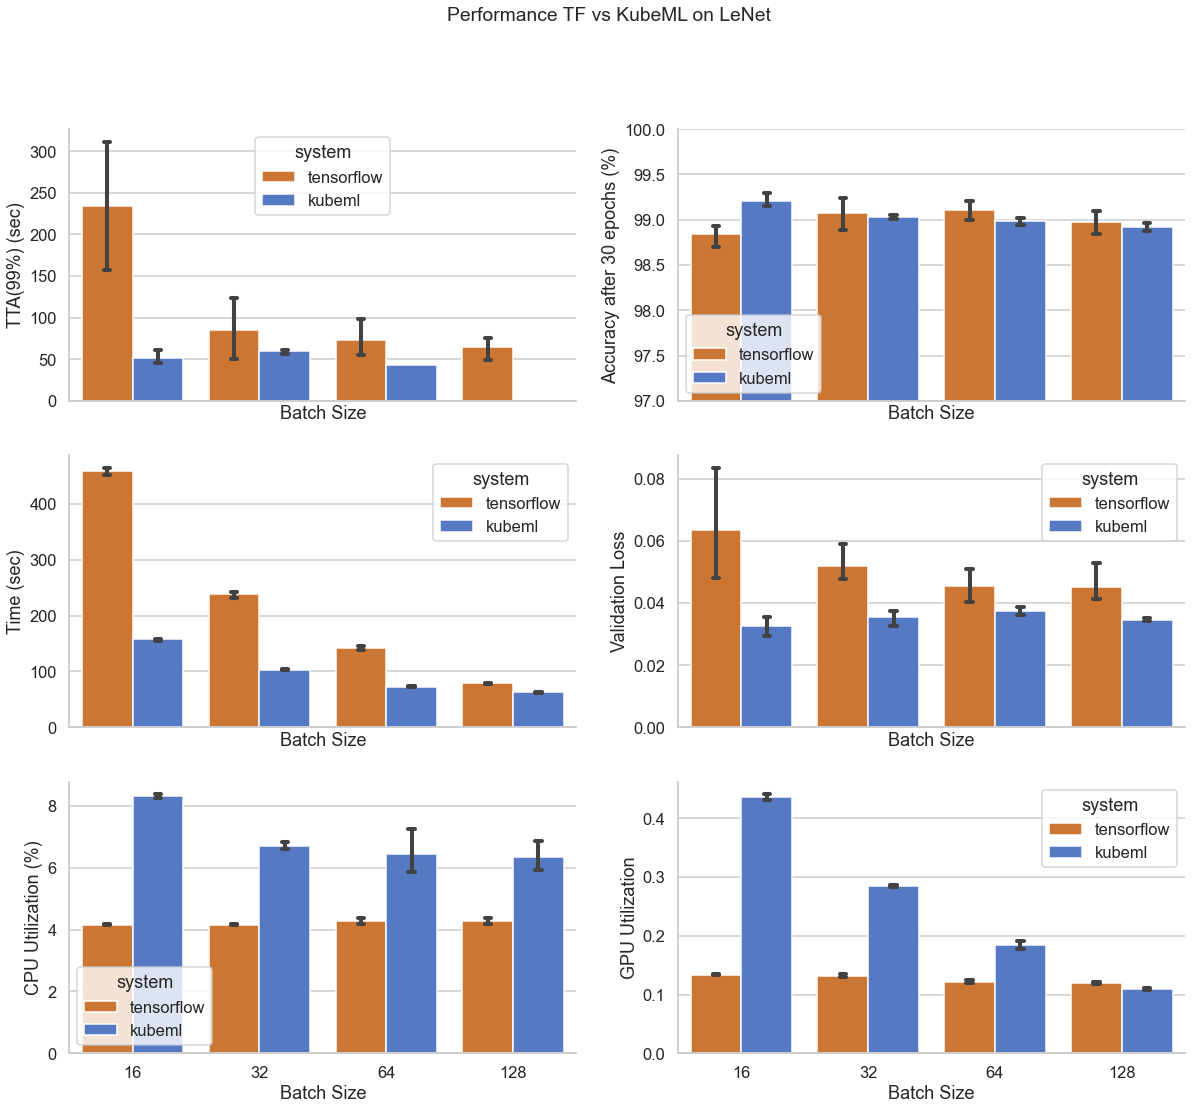

In [173]:
# get only the results with k=-1 and 
_l = l[((l.parallelism==4) | (l.parallelism.isna())) & ((l.k==float('inf')) | (l.k.isna())) ]

# set the palette
sns.set_palette([tf_color, kubecolor], desat=0.8)


# COMPARE THE LOSSES, THE VAL LOSS OF KUBEML SHOULD BE HIGHER (DO NOT KNOW THE TRAIN LOSS, BECAUSE OF EXPLORATION,
# WHILE STILL GIVING BEST ACCURACY (BETTER GENERALIZATION))
f, ax = plt.subplots(3, 2, sharex=True, figsize=(20, 17))

# 1) Plot the comparison of tta between both
sns.barplot(x='batch_size', 
            y='tta_99', 
            data=_l, 
            hue='system',
            capsize=.05,
            ax=ax[0][0])
ax[0][0].set_xlabel('Batch Size')
ax[0][0].set_ylabel('TTA(99%) (sec)')


# 2) Plot the max accuracy
sns.barplot(x='batch_size', 
            y='acc', 
            data=_l, 
            hue='system', 
            capsize=.05,
            ax=ax[0][1])
ax[0][1].set_ylim([97, 100])
ax[0][1].set_xlabel('Batch Size')
ax[0][1].set_ylabel('Accuracy after 30 epochs (%)')


# 3) Plot the difference in GPU utilzation
sns.barplot(x='batch_size', 
            y='time', 
            data=_l, 
            hue='system', 
            capsize=.05,
            ax=ax[1][0])
ax[1][0].set_xlabel('Batch Size')
ax[1][0].set_ylabel('Time (sec)')


# 4) Plot the val loss of both compared
# calculate the loss
_l['loss'] = _l['validation_loss'].map(lambda l:l[-1])
sns.barplot(x='batch_size', 
            y='loss', 
            data=_l ,
            capsize=.05,
            hue='system',
            ax=ax[1][1])

ax[1][1].set_xlabel('Batch Size')
ax[1][1].set_ylabel('Validation Loss')

plt.suptitle('Performance TF vs KubeML on LeNet')


## Plot the difference in cpu and gpu utilization
# CPU util
sns.barplot(x='batch_size', 
            y='cpu_mean', 
            data=_l ,
            capsize=.05,
            hue='system',
            ax=ax[2][0])

ax[2][0].set_xlabel('Batch Size')
ax[2][0].set_ylabel('CPU Utilization (%)')

# GPu Util
sns.barplot(x='batch_size', 
            y='gpu_usage', 
            data=_l ,
            capsize=.05,
            hue='system',
            ax=ax[2][1])

ax[2][1].set_xlabel('Batch Size')
ax[2][1].set_ylabel('GPU Utilization')


sns.despine()

# plt.savefig('./figures/ppt/lenet-performance.png', dpi=400)

### Comparison of accuracy and time between K

In [ ]:
f, ax = plt.subplots(1, 2, sharex=True, figsize=(20, 10))



_kubelenet = l[(l.system == 'kubeml')]
# 1) plot the accuracy reached with different k
sns.barplot(x='batch_size',
           y='time',
           data=_kubelenet, 
           hue='parallelism',
           ax=ax[0])
ax[0].set_xlabel('Batch Size')
ax[0].set_ylabel('Time (sec)')


_kubelenet = l[(l.system == 'kubeml') & (l.parallelism==4)]
# 2) plot the time reached with different k
sns.barplot(x='batch_size',
           y='time',
           data=_kubelenet, 
           hue='k',
           ax=ax[1])
ax[1].set_xlabel('Batch Size')
ax[1].set_ylabel('Time (sec)')

plt.suptitle('Evolution of Time with Parallelism and K')

plt.savefig('./figures/ppt/lenet-time.png', dpi=400)

## Resnet Results

#### Plot the Train Loss and Val Accuracy of Tensorflow and KubeML


In [194]:
# set the palette
sns.set_palette([tf_color, kubecolor], desat=0.8)

In [ ]:
r = pd.read_pickle('./dataframes/resnet_new.pkl')

In [ ]:
r[(r.batch_size==32) & (r.system=='kubeml') & (r.k == float('inf')) & (r.parallelism ==4)].iloc[0].epoch_duration

In [205]:
tf.sort_values('tta_70')

,model,hash,batch_size,epochs,train_loss,train_accuracy,validation_loss,accuracy,epoch_duration,acc,...,dataset,lr,function_name,default_parallelism,static_parallelism,validate_every,k,goal_accuracy,parallelism,global_batch
2,resnet,897dac71b62ec136,256,70,"[2.588197708129883, 1.6263797283172607, 1.4347...","[0.283160001039505, 0.4254800081253052, 0.4895...","[2.97422456741333, 1.4934394359588623, 1.49471...","[25.940001010894775, 46.11999988555908, 47.929...","[28.42989730834961, 40.05997085571289, 51.5759...",69.830000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,resnet,897dac71b62ec136,256,70,"[2.920346975326538, 1.716526985168457, 1.50120...","[0.2539199888706207, 0.40053999423980713, 0.46...","[173.22474670410156, 1.9153906106948853, 1.627...","[10.890000313520432, 36.30000054836273, 43.909...","[28.510070085525513, 40.43153119087219, 51.954...",69.520003,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,resnet,5d4210e3130a9739,128,70,"[2.751002073287964, 1.7799159288406372, 1.6000...","[0.20479999482631683, 0.3450799882411957, 0.42...","[2.1896557807922363, 1.725273847579956, 1.7479...","[20.76999992132187, 36.86000108718872, 37.5, 4...","[36.689316272735596, 58.4234185218811, 80.2069...",71.880001,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,resnet,ad67202e9061c34e,64,70,"[2.3951144218444824, 1.7598485946655273, 1.599...","[0.2266400009393692, 0.35763999819755554, 0.42...","[1.9135148525238037, 1.7065120935440063, 1.471...","[27.559998631477356, 36.410000920295715, 47.04...","[53.67754888534546, 92.38472270965576, 131.467...",70.789999,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,resnet,ad67202e9061c34e,64,70,"[2.4347894191741943, 1.7202712297439575, 1.561...","[0.23890000581741333, 0.3774400055408478, 0.44...","[2.0604264736175537, 1.8974347114562988, 1.554...","[28.439998626708984, 33.53999853134155, 48.660...","[56.1527099609375, 97.59916090965271, 139.2464...",70.190001,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,resnet,44d99b585ec15030,32,70,"[2.440882444381714, 1.9447448253631592, 1.7837...","[0.17066000401973724, 0.26809999346733093, 0.3...","[2.0373032093048096, 1.7875392436981201, 1.791...","[21.709999442100525, 31.139999628067017, 38.22...","[90.5465760231018, 167.67973113059998, 243.727...",70.819998,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,resnet,ad67202e9061c34e,64,70,"[2.4401824474334717, 1.793631911277771, 1.5875...","[0.21024000644683838, 0.337660014629364, 0.436...","[2.2239508628845215, 2.1312508583068848, 1.594...","[22.619999945163727, 29.420000314712524, 44.15...","[55.99747109413147, 97.27349877357483, 138.634...",70.749998,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,resnet,44d99b585ec15030,32,70,"[2.3818185329437256, 1.8773642778396606, 1.776...","[0.18386000394821167, 0.2983599901199341, 0.36...","[1.942749261856079, 1.838205099105835, 1.63964...","[26.53000056743622, 34.56999957561493, 43.0400...","[96.54499387741089, 177.19756150245667, 256.99...",71.450001,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,resnet,44d99b585ec15030,32,70,"[2.4327855110168457, 1.8787837028503418, 1.705...","[0.1796800047159195, 0.310699999332428, 0.3950...","[1.9519758224487305, 1.7863093614578247, 2.088...","[26.179999113082886, 37.290000915527344, 39.77...","[96.81992959976196, 177.93973994255066, 258.48...",69.900000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,resnet,5d4210e3130a9739,128,70,"[2.7905611991882324, 1.7551709413528442, 1.588...","[0.20681999623775482, 0.3425599932670593, 0.42...","[1.957597017288208, 1.6984312534332275, 1.5086...","[25.65999925136566, 36.8800014257431, 44.74999...","[34.91643500328064, 55.42659902572632, 75.9164...",68.580002,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<AxesSubplot:ylabel='train_loss'>

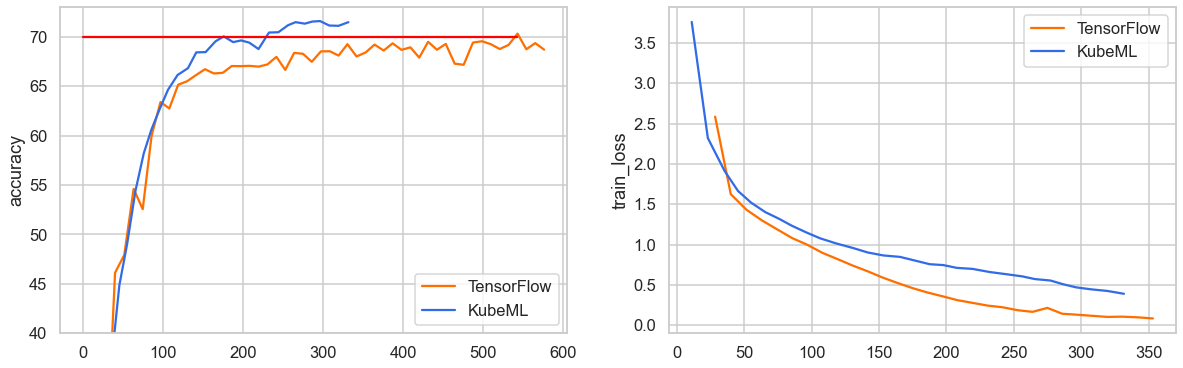

In [212]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=False, figsize=(20, 6))

# get the best results
tf = r[r.system=='tensorflow']
ml = r[r.system =='kubeml']
sample = tf.iloc[2]
kubesample = r.iloc[61]

# sort for tta69 and show

# 1) plot the validation accuracy of TF
sns.lineplot(x=sample.epoch_duration[:50],
             y=sample.accuracy[:50],
             data=sample, 
            ax=ax1, 
            label='TensorFlow',
            color='#FF6F00')

# 2) plot the validation accuracy of KubeML
sns.lineplot(x=kubesample.epoch_duration,
             y='accuracy',
             data=kubesample, 
            ax=ax1, 
            label='KubeML',
            color='#316CE6')

ax1.set_ylim([40, 73])



# plot the line at 69%
sns.lineplot(x=range(int(sample.tta_70)),
            y=70,
            ax=ax1,
            color='red')


# 3) Plot the train loss
sns.lineplot(x=sample.epoch_duration[:30],
             y=sample.train_loss[:30],
             data=sample, 
            ax=ax2, 
            label='TensorFlow',
            color='#FF6F00')

# 3) Plot the train loss
sns.lineplot(x=kubesample.epoch_duration,
             y='train_loss',
             data=kubesample, 
            ax=ax2, 
            label='KubeML',
            color='#316CE6')


### Plot the metrics of both 

c:\users\diego\cs\qpe\venv\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
c:\users\diego\cs\qpe\venv\lib\site-packages\ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\users\diego\cs\qpe\venv\lib\site-packages\ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer

Text(0.5, 0.98, 'Performance TF vs KubeML on Resnet34')

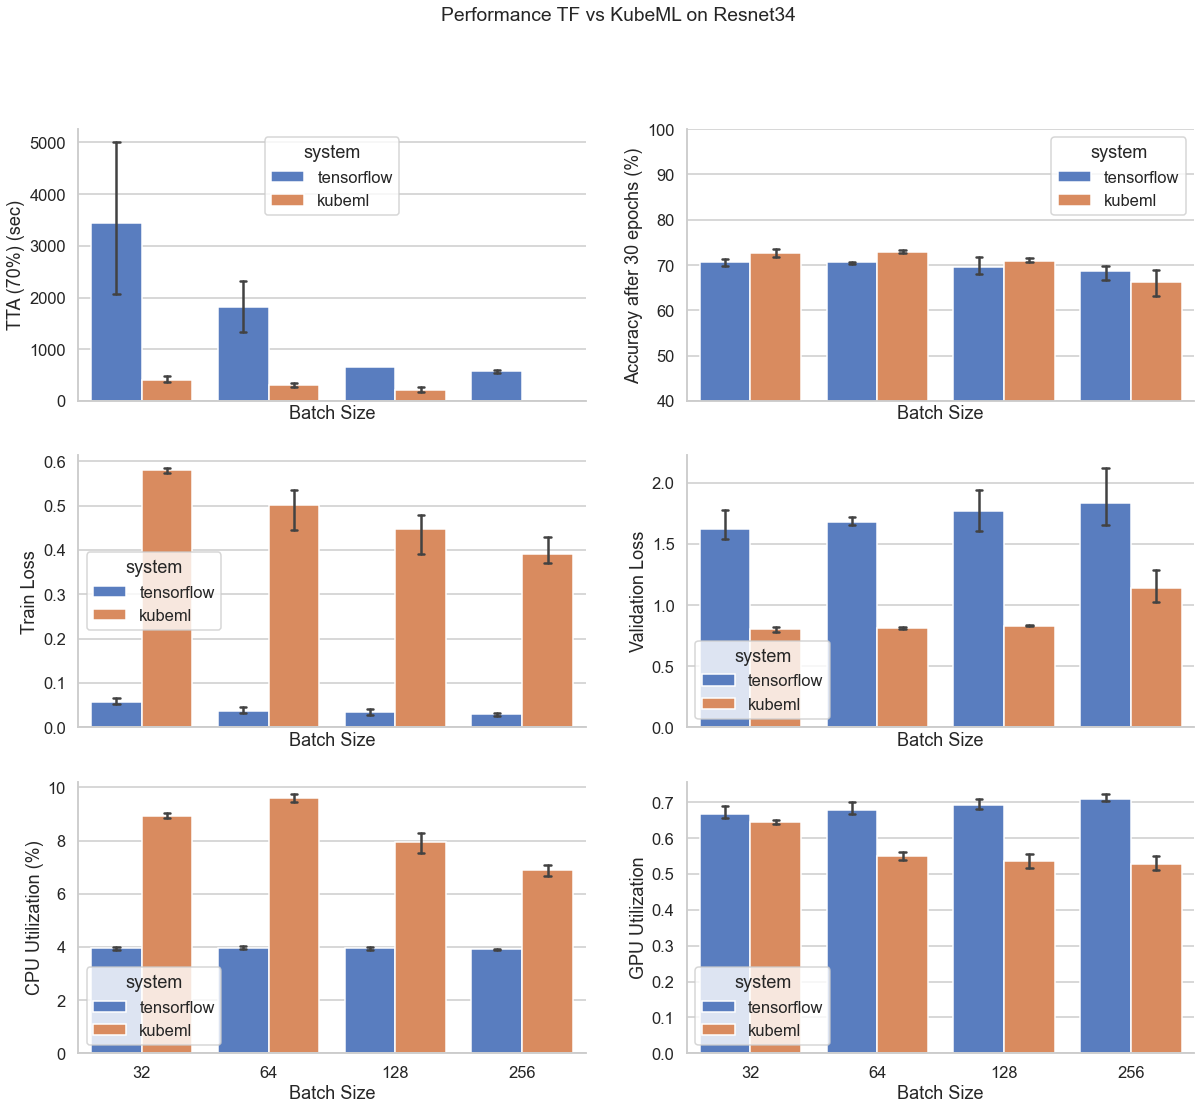

In [219]:
# get only the results with k=-1 and 
_r = r[((r.parallelism==4) | (r.parallelism.isna())) & ((r.k==float('inf')) | (r.k.isna())) ]
_r['t30'] = _r['time']


# COMPARE THE LOSSES, THE VAL LOSS OF KUBEML SHOULD BE HIGHER (DO NOT KNOW THE TRAIN LOSS, BECAUSE OF EXPLORATION,
# WHILE STILL GIVING BEST ACCURACY (BETTER GENERALIZATION))
f, ax = plt.subplots(3, 2, sharex=True, figsize=(20, 17))

# 1) Plot the comparison of tta between both
sns.barplot(x='batch_size', 
            y='tta_70', 
            data=_r, 
            hue='system', 
            errwidth=2.5,
            ax=ax[0][0],
           capsize=.05)
ax[0][0].set_xlabel('Batch Size')
ax[0][0].set_ylabel('TTA (70%) (sec)')


# 2) Plot the max accuracy
sns.barplot(x='batch_size', 
            y='acc', 
            data=_r, 
            hue='system', 
            errwidth=2.5,
            ax=ax[0][1],
            capsize=.05)
ax[0][1].set_ylim([40, 100])
ax[0][1].set_xlabel('Batch Size')
ax[0][1].set_ylabel('Accuracy after 30 epochs (%)')


# 3) Plot the difference in GPU utilzation
_r['t_loss'] = _r['train_loss'].map(lambda l:l[-1])
sns.barplot(x='batch_size', 
            y='t_loss', 
            data=_r, 
            hue='system',
            errwidth=2.5,
            ax=ax[1][0],
            capsize=.05,
               )
ax[1][0].set_xlabel('Batch Size')
ax[1][0].set_ylabel('Train Loss')


# 4) Plot the val loss of both compared
# calculate the loss
_r['loss'] = _r['validation_loss'].map(lambda l:l[-1])
sns.barplot(x='batch_size', 
            y='loss', 
            data=_r ,
            hue='system',
            errwidth=2.5,
            ax=ax[1][1],
            capsize=.05)

ax[1][1].set_xlabel('Batch Size')
ax[1][1].set_ylabel('Validation Loss')


## Plot the difference in cpu and gpu utilization
# CPU util
sns.barplot(x='batch_size', 
            y='cpu_mean', 
            data=_r ,
            capsize=.05,
            errwidth=2.5,
            hue='system',
            ax=ax[2][0])

ax[2][0].set_xlabel('Batch Size')
ax[2][0].set_ylabel('CPU Utilization (%)')

# GPu Util
sns.barplot(x='batch_size', 
            y='gpu_usage', 
            data=_r ,
            capsize=.05,
            errwidth=2.5,
            hue='system',
            ax=ax[2][1])

ax[2][1].set_xlabel('Batch Size')
ax[2][1].set_ylabel('GPU Utilization')


sns.despine()
plt.suptitle('Performance TF vs KubeML on Resnet34')

# plt.savefig('./figures/ppt/resnet-performance.png', dpi=400)


### Comparison of Time with Parallelism and K

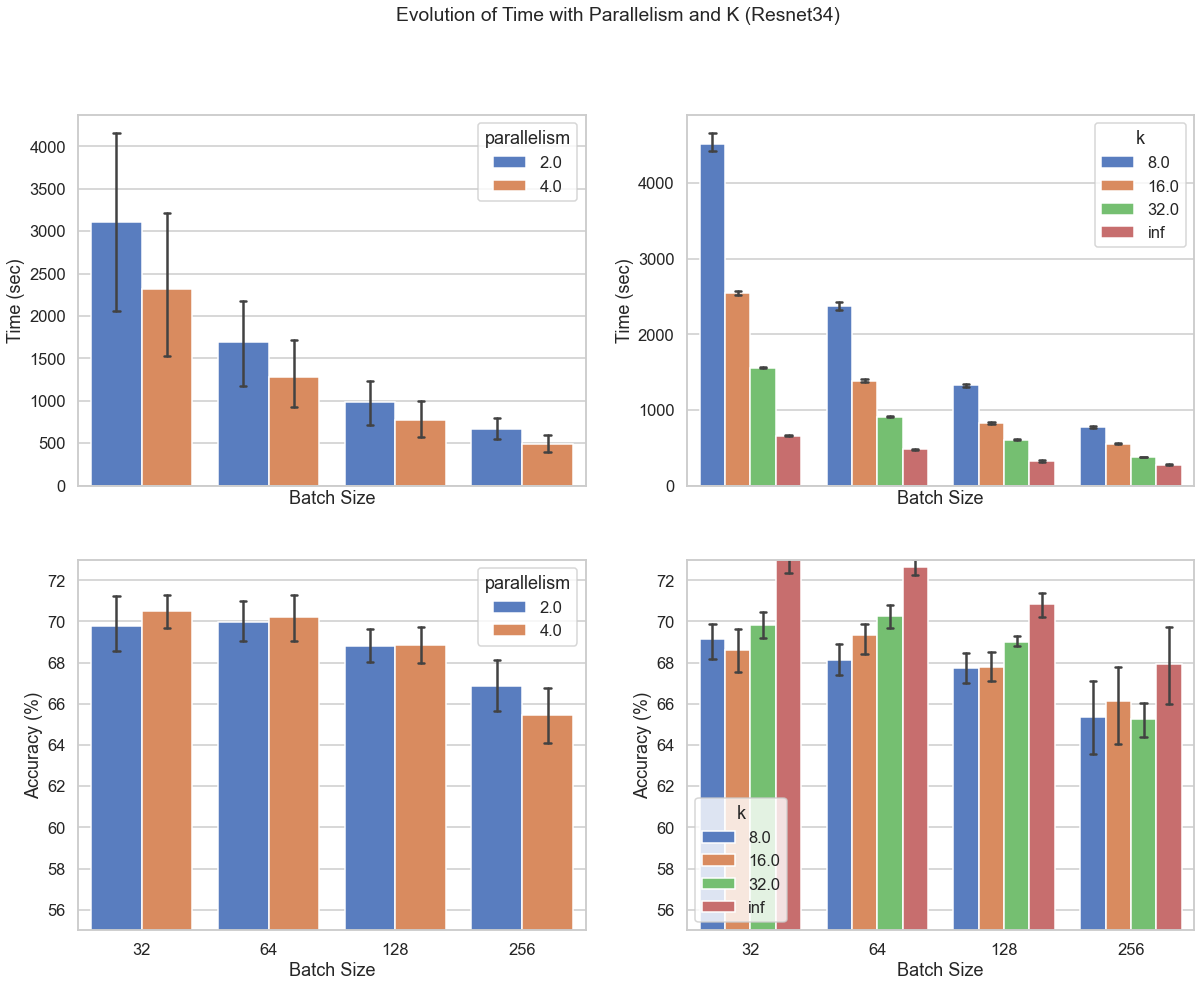

In [197]:
f, (ax1, ax2) = plt.subplots(2, 2, sharex=True, figsize=(20, 15))

sns.set_palette('muted',10)

_kuberesnet = r[(r.system == 'kubeml')]
# 1) plot the accuracy reached with different k
sns.barplot(x='batch_size',
           y='time',
           data=_kuberesnet, 
            errwidth=2.5,
            capsize=.05,
           hue='parallelism',
           ax=ax1[0])
ax1[0].set_xlabel('Batch Size')
ax1[0].set_ylabel('Time (sec)')





_kuberesnet = r[(r.system == 'kubeml') & (r.parallelism==4)]
# 2) plot the time reached with different k
sns.barplot(x='batch_size',
           y='time',
           data=_kuberesnet, 
            capsize=.05,
           hue='k',
        errwidth=2.5,
           ax=ax1[1])
ax1[1].set_xlabel('Batch Size')
ax1[1].set_ylabel('Time (sec)')



_kuberesnet = r[(r.system == 'kubeml')]
# 1) plot the accuracy reached with different k
sns.barplot(x='batch_size',
           y='acc',
           data=_kuberesnet, 
           hue='parallelism',
            capsize=.05,
            errwidth=2.5,
           ax=ax2[0])
ax2[0].set_xlabel('Batch Size')
ax2[0].set_ylabel('Accuracy (%)')
ax2[0].set_ylim([55, 73])


_kuberesnet = r[(r.system == 'kubeml')]
# 1) plot the accuracy reached with different k
sns.barplot(x='batch_size',
           y='acc',
            errwidth=2.5,
            capsize=.05,
           data=_kuberesnet, 
           hue='k',
           ax=ax2[1])
ax2[1].set_xlabel('Batch Size')
ax2[1].set_ylabel('Accuracy (%)')
ax2[1].set_ylim([55, 73])

plt.suptitle('Evolution of Time with Parallelism and K (Resnet34)')

plt.savefig('./figures/ppt/resnet-time.png', dpi=400)

In [ ]:
g = _r.loc[(_r.batch_size==32) & (_r.system=='kubeml')]
for a, t in zip(g.iloc[0].accuracy, g.iloc[0].epoch_duration):
    print(t, a)

## Do ANOVA Linear Model to calculate the influence of the parameters

Using ANOVA we can get an idea of how the different parameters interact with each other and their influence

In [213]:
# For the ANOVA test
import researchpy as rp
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [214]:
def ANOVA(df: pd.DataFrame, y: str, use_all = False,verbose=False):
    """Run the ANOVA analysis with the batch, k and parallelism columns for the 
    given output variable"""
    
    # If use all is true we use all the variables to check either accuracy and time
    # including also the iowait and the cpu to see what fully influences the stuff
    
    
    if not use_all:
        # Plot the summary dataframe
        if verbose:
            display(rp.summary_cont(df.groupby(['batch_size', 'k', 'parallelism']))[y])

        model = ols(f'{y} ~ batch_size*k*parallelism', df).fit()
        
    else:
        if y not in ['acc', 'time']:
            raise ValueError('When use_all = True we predict either final_accuracy or time, not', y)
        if verbose:
            display(rp.summary_cont(df.groupby(['batch_size', 'k', 'parallelism']))[y])

        model = ols(f'{y} ~ cpu*batch*njobs*cpu_mean*iowait_mean', df).fit()
        

    if verbose:
        print(f"Overall model F({model.df_model: .0f},{model.df_resid: .0f}) = {model.fvalue: .3f}, p = {model.f_pvalue: .4f}")
        display(model.summary())
    
    res = sm.stats.anova_lm(model, typ=2)
    
    return res, model

In [217]:
# df.k = df.k.map(lambda val: -1 if val == float('inf') else val)

__r = r[r.system=='kubeml']
__r['k'] = __r['k'].map(lambda v: -1 if v == float('inf') else v)
res, model = ANOVA(__r, y='gpu_usage', verbose=True)

res



c:\users\diego\cs\qpe\venv\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
c:\users\diego\cs\qpe\venv\lib\site-packages\scipy\stats\_distn_infrastructure.py:2023: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
c:\users\diego\cs\qpe\venv\lib\site-packages\scipy\stats\_distn_infrastructure.py:2024: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


N    Mean      SD      SE  95% Conf.  Interval
batch_size k     parallelism                                                
32         -1.0  2.0          3  0.4199  0.0028  0.0016     0.4129    0.4269
                 4.0          3  0.6444  0.0059  0.0034     0.6297    0.6591
            8.0  2.0          3  0.0825  0.0001  0.0001     0.0821    0.0828
                 4.0          3  0.1251  0.0055  0.0032     0.1116    0.1387
            16.0 2.0          3  0.1327  0.0002  0.0001     0.1323    0.1331
                 4.0          3  0.1938  0.0091  0.0053     0.1712    0.2165
            32.0 2.0          3  0.2082  0.0115  0.0066     0.1797    0.2366
                 4.0          3  0.2882  0.0018  0.0011     0.2837    0.2928
64         -1.0  2.0          3  0.3886  0.0058  0.0034     0.3742    0.4030
                 4.0          3  0.5501  0.0111  0.0064     0.5226    0.5776
            8.0  2.0          3  0.0952  0.0011  0.0006     0.0924    0.0979
                 4.0          3  0.1333  0.0171  0.0099     0.0908    0.1759
            16.0 2.0          3  0.1471  0.0019  0.0011     0.1422    0.1519
                 4.0          3  0.2121  0.0079  0.0046     0.1925    0.2318
            32.0 2.0          3  0.2237  0.0078  0.0045     0.2043    0.2431
                 4.0          3  0.3030  0.0107  0.0062     0.2763    0.3297
128        -1.0  2.0          3  0.3631  0.0025  0.0014     0.3570    0.3692
                 4.0          3  0.5353  0.0196  0.0113     0.4866    0.5839
            8.0  2.0          3  0.1131  0.0007  0.0004     0.1115    0.1148
                 4.0          3  0.1582  0.0124  0.0071     0.1274    0.1889
            16.0 2.0          3  0.1700  0.0017  0.0010     0.1657    0.1743
                 4.0          3  0.2407  0.0041  0.0024     0.2305    0.2509
            32.0 2.0          3  0.2275  0.0040  0.0023     0.2175    0.2376
                 4.0          3  0.3093  0.0068  0.0039     0.2925    0.3261
256        -1.0  2.0          3  0.3403  0.0075  0.0043     0.3216    0.3590
                 4.0          3  0.5266  0.0211  0.0122     0.4743    0.5790
            8.0  2.0          3  0.1491  0.0047  0.0027     0.1375    0.1608
                 4.0          3  0.2099  0.0126  0.0073     0.1786    0.2412
            16.0 2.0          3  0.2068  0.0174  0.0101     0.1635    0.2500
                 4.0          3  0.2883  0.0050  0.0029     0.2760    0.3006
            32.0 2.0          3  0.2666  0.0049  0.0028     0.2544    0.2787
                 4.0          3  0.4015  0.0123  0.0071     0.3711    0.4320

Overall model F( 7, 88) =  4.374, p =  0.0003


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              gpu_usage   R-squared:                       0.258
Model:                            OLS   Adj. R-squared:                  0.199
Method:                 Least Squares   F-statistic:                     4.374
Date:                Tue, 20 Apr 2021   Prob (F-statistic):           0.000334
Time:                        11:42:01   Log-Likelihood:                 64.857
No. Observations:                  96   AIC:                            -113.7
Df Residuals:                      88   BIC:                            -93.20
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    0.1358      0.108      1.259      0.211      -0.079       0.350
batch_size               -2.528e-05      0.001     -0.035      0.972      -0.001       0.001
k                           -0.0014      0.006     -0.237      0.813      -0.013       0.010
batch_size:k              4.965e-06   3.99e-05      0.125      0.901   -7.43e-05    8.42e-05
parallelism                  0.0649      0.034      1.903      0.060      -0.003       0.133
batch_size:parallelism    -1.69e-05      0.000     -0.073      0.942      -0.000       0.000
k:parallelism               -0.0015      0.002     -0.816      0.417      -0.005       0.002
batch_size:k:parallelism  4.567e-06   1.26e-05      0.362      0.718   -2.05e-05    2.96e-05
==============================================================================
Omnibus:                       21.322   Durbin-Watson:                   1.889
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                4.988
Skew:                          -0.056   Prob(JB):                       0.0826
Kurtosis:                       1.889   Cond. No.                     7.68e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.68e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

,sum_sq,df,F,PR(>F)
batch_size,0.023063,1.0,1.394488,0.240830
k,0.194437,1.0,11.756559,0.000924
batch_size:k,0.036236,1.0,2.190976,0.142393
parallelism,0.235709,1.0,14.252091,0.000290
batch_size:parallelism,0.001488,1.0,0.089978,0.764913
k:parallelism,0.013280,1.0,0.803000,0.372643
batch_size:k:parallelism,0.002169,1.0,0.131156,0.718104
Residual,1.455393,88.0,NaN,NaN
